<a href="https://colab.research.google.com/github/mehdimerbah/TDA-PPIN/blob/main/preprocessing/Cleaned_DataPreprocessing_PPI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Package Installation and Loading


Main packages to analyse the persistent homology of the network dataset are: ripser, persim and NetworkX.    
**ripser**: A lean python package for analysing persistent homology. (Builds on c++ Ripser library).   
**persim**: A python package for analyzing persistence diagrams generated from ripser.   
**NetworkX**: NetworkX is a Python package for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks.


In [ ]:
! pip3 install ripser

In [ ]:
! pip3 install giotto-tda

In [2]:
import pandas as pd
import numpy as np
import networkx as nwx
from ripser import ripser
from persim import plot_diagrams
from scipy.spatial.distance import pdist, squareform
from scipy.sparse import coo_matrix
#from gtda.graphs import GraphGeodesicDistance
#from gtda.homology import VietorisRipsPersistence, SparseRipsPersistence, FlagserPersistence
from igraph import Graph
from IPython.display import SVG, display
import matplotlib.pyplot as plt
from pyvis.network import Network

We are fetching the raw data directly from the GCN study repository (temporarily). We should update these datasets from the original sources as new data became available for both the PPI network and the CORUM Human complexes.


In [ ]:
! wget https://raw.githubusercontent.com/hars-singh/GCN_complex_detection/main/Datasets/Human/CORUM-Human-Complexes_r.txt

/bin/bash: wget: command not found


In [ ]:
! wget https://raw.githubusercontent.com/hars-singh/GCN_complex_detection/main/Datasets/Human/GOSemSim_Wang_combined_BIOGRID-ORGANISM-Homo_sapiens.txt -O Human_PPI_Network.txt

/bin/bash: wget: command not found


# Exploring PPI Network Data

In [3]:
## Here we load the PPI network data. The dataset is constructed by combinging BioGrid data for potein interaction pairs,
## with their GO Semantic Similarity score calulated using Wang method. (Wang. 2007)
ppi_df = pd.read_table("../data/Human_PPI_Network.txt", header=None)
ppi_df.columns = ["ProteinA", "ProteinB", "SemSim"]

In [4]:
## The GO Semantic Similarity score range from 0.0 to 1.0 from lowest to highest level of similarity
ppi_df.head(10)

,ProteinA,ProteinB,SemSim
0,FLNC,MAP2K4,0.672667
1,ACTN2,MYPN,0.738667
2,ACVR1,FNTA,0.370000
3,PML,GATA2,0.632667
4,STAT3,RPA2,0.576000
5,ARF1,GGA3,0.447000
6,ARF3,ARFIP2,0.241667
7,ARF3,ARFIP1,0.347333
8,ALDOA,XRN1,0.466333
9,APP,APPBP2,0.408333


In [5]:
ppi_df.sort_values(by=['SemSim'], ascending=False)

,ProteinA,ProteinB,SemSim
193691,ND4,NDUFS6,1.0
73921,MRPL4,MRPL2,1.0
298878,EFTUD2,FRG1,1.0
124168,KRTAP12-2,KRTAP5-9,1.0
124169,KRTAP12-1,KRTAP5-9,1.0
...,...,...,...
137465,CCDC101,ACTG1,0.0
137464,CCDC101,TADA2B,0.0
137463,CCDC101,SF3B5,0.0
137462,CCDC101,TAF12,0.0


## Testing NetworkX Package on PPI Data

In [ ]:
## Take a subset of the dataframe for a specific protein to visualize the graph
subset_df = ppi_df[ppi_df['ProteinA'] == 'MAP2K4']
subset_df.sort_values(by=['SemSim'], ascending=False)

In [ ]:
n_subset_df = ppi_df[ppi_df['ProteinB'] == 'MAP2K4']
n_subset_df.sort_values(by=['SemSim'], ascending=False)

In [ ]:
G_0 = nwx.from_pandas_edgelist(
    n_subset_df,
    source='ProteinA',
    target='ProteinB',
    edge_attr='SemSim'
)


In [ ]:
nwx.degree(G_0)

DegreeView({'FLNC': 1, 'MAP2K4': 35, 'MAPK8': 1, 'MAP4K2': 1, 'MAP2K7': 1, 'MAP3K8': 1, 'AKT1': 1, 'MAP3K11': 1, 'MAP3K4': 1, 'ARRB2': 1, 'MAP3K2': 1, 'MAP3K1': 1, 'ITCH': 1, 'MAPK9': 1, 'PML': 1, 'MAPK10': 1, 'MAP3K5': 1, 'MAP2K6': 1, 'MAPK14': 1, 'MAP3K3': 1, 'LRRK2': 1, 'APP': 1, 'JUN': 1, 'MAP3K7': 1, 'MAPK1': 1, 'GCH1': 1, 'GEMIN5': 1, 'RBBP8': 1, 'EGFR': 1, 'MAP3K10': 1, 'NBR1': 1, 'KTI12': 1, 'VASP': 1, 'FLNB': 1, 'CDC5L': 1, 'TRIM25': 1})

In [ ]:
scaled_degree = [d[1] * 200 for d in nwx.degree(G_0)]
nwx.draw(G_0,
        # Weights Based on Column
        width=list(nwx.get_edge_attributes(G_0, 'SemSim').values()),
        # Node size based on degree
        node_size=scaled_degree,
        # Colour Based on Degree
        node_color=scaled_degree,
        # Set color map to determine colours
        cmap='rainbow',
        with_labels=True)


# Exploring Protein Complexes Data
This data was collected from the CORUM database. These are from the 3.0 database and were downloaded directly from the Github repository for the study. We should refer to the latest CORUM 4.0 update for a more comprehensive list of complexes.


In [6]:
complexes_list = []
with open("../data/CORUM_Human_Complexes.txt") as complexes:
  for line in complexes:
    line = line.strip()
    temp_list = list(line.split("\t"))
    complexes_list.append(temp_list)

print(complexes_list)

[['BCL6', 'HDAC4'], ['BCL6', 'HDAC5'], ['BCL6', 'HDAC7'], ['NCOA3', 'EP300', 'KAT2B', 'CREBBP'], ['NCAPG', 'SMC2', 'SMC4', 'NCAPD2', 'NCAPH'], ['HPS4', 'HPS1'], ['HPS5', 'HPS6', 'HPS3'], ['CDS1', 'MUS81'], ['HDAC3', 'TBL1X', 'TBL1XR1', 'GPS2', 'CORO2A', 'NCOR1'], ['BLOC1S6', 'BLOC1S5', 'BLOC1S4', 'BLOC1S3', 'BLOC1S2', 'BLOC1S1', 'DTNBP1', 'SNAPIN'], ['ARPC3', 'ARPC1B', 'ARPC5', 'ARPC4', 'ARPC2', 'ACTR3', 'ACTR2'], ['PSME2', 'PSME1'], ['PSMD1', 'PSMD9', 'PSMD8', 'PSMD5', 'PSMD14', 'PSMD7', 'PSMD6', 'PSMD11', 'PSMD10', 'PSMD3', 'PSMD12', 'PSMD2', 'PSMD13', 'PSMD4', 'PSMC1', 'PSMC2', 'PSMC3', 'PSMC4', 'PSMC5', 'PSMC6'], ['PFDN1', 'PFDN2', 'PFDN5', 'VBP1', 'PFDN6', 'PFDN4'], ['AP1M2', 'AP1G1', 'AP1G2', 'AP1M1', 'AP1S1', 'AP1S2', 'AP1S3', 'AP1B1'], ['HDAC1', 'BCL6', 'MBD3', 'MTA2', 'MTA3'], ['PSENEN', 'PSEN1', 'APH1A', 'NCSTN'], ['HDAC1', 'DNMT3B', 'SMC2', 'SMC4', 'KIF4A', 'SMARCA5', 'SIN3A'], ['RABGEF1', 'RAB5A', 'RABEP1'], ['HDAC1', 'HDAC2', 'SAP30', 'RBBP7', 'RBBP4', 'SAP18', 'SIN3A'], [

In [7]:
print(len(complexes_list))
## We have 2645 protein complexes

2645


In [15]:
# Check the largest complex
largest_idx = 0
for idx, cmplx in enumerate(complexes_list):
  if len(cmplx) > len(complexes_list[largest_idx]):
    largest_idx = idx
print(largest_idx)
# The largest Protein Complex includes 143 individual proteins at index 171.

171


In [14]:
len(complexes_list[171])

143

## Testing NetworkX Package on Complexes Data

In [ ]:
test_complex = complexes_list[171]
test_complex_ppi_df = ppi_df[(ppi_df['ProteinA'].isin(test_complex)) & (ppi_df['ProteinB'].isin(test_complex)) ]
test_complex_ppi_df.sort_values(by='SemSim')


,ProteinA,ProteinB,SemSim
333894,DHX38,KIAA1429,0.0
333335,KIAA1429,PRPF6,0.0
333418,DDX23,KIAA1429,0.0
333503,KIAA1429,SF3B2,0.0
228607,DGCR14,SNRPE,0.0
...,...,...,...
3002,PPIL3,SLU7,1.0
227684,SYF2,CDC40,1.0
88800,RBM17,CWC15,1.0
88797,RBM17,U2SURP,1.0


In [ ]:
test_G = nwx.from_pandas_edgelist(
    test_complex_ppi_df,
    source='ProteinA',
    target='ProteinB',
    edge_attr='SemSim'
)

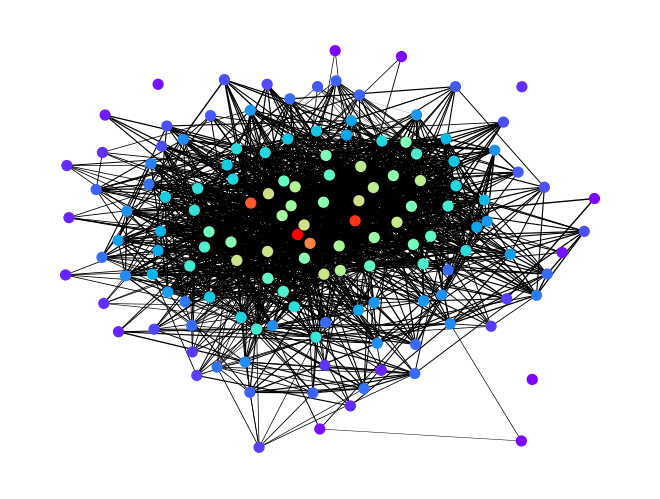

In [ ]:
scaled_degree = [d[1]*10 for d in nwx.degree(test_G)]
nwx.draw_kamada_kawai(test_G,
        # Weights Based on Column
        width=list(nwx.get_edge_attributes(test_G, 'SemSim').values()),
        # Node size based on degree
        node_size=50,
        # Colour Based on Degree
        node_color=scaled_degree,
        # Set color map to determine colours
        cmap='rainbow',
        with_labels=False)

## Distance Matrix Generation and Persistent Homology Testing

We generate a distance matrix. Using distance as a metric measure is a way of interpresting the graph topological space as a metric space. This should give us a good measure of node distances as measured by shortest path (Floyd-Warshall)

In [ ]:
D = np.array(nwx.floyd_warshall_numpy(test_G))
D

We can now use ripser to generate some persistence diagrams.

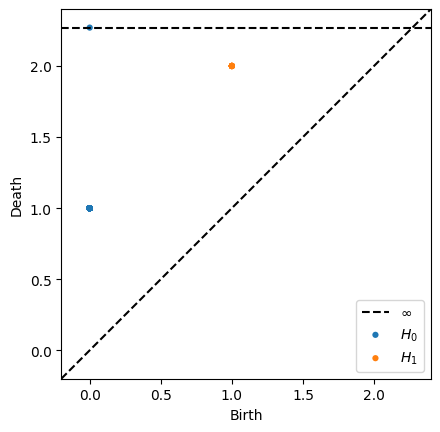

In [ ]:
diag = ripser(D,distance_matrix=True)['dgms']
plot_diagrams(diag)

/opt/homebrew/lib/python3.11/site-packages/ripser/ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(


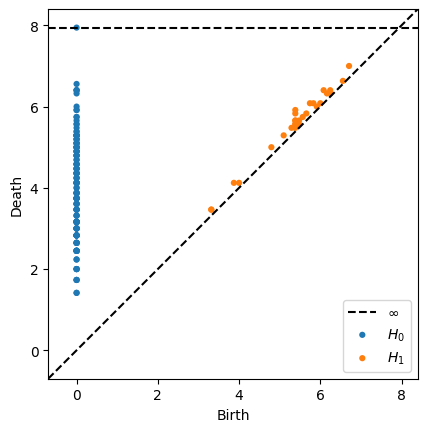

In [ ]:
## let's test the homology using an adjacency matrix instead
diags = ripser(nwx.adjacency_matrix(test_G), distance_matrix=False)['dgms']
plot_diagrams(diags)

We should now cluster the components to identify the protein sub-communities/hubs that have potential to form a complex.

In [ ]:
threshold = 0.2

complexes = []
for i, dgm in enumerate(diag):
    for pt in dgm:
        if pt[1] - pt[0] > threshold:
            complex_nodes = [node for node in test_G.nodes if test_G.nodes[node]['component'] == i]
            complexes.append(complex_nodes)

# Visualize the identified complexes
for i, complex_nodes in enumerate(complexes):
    print(f'Complex {i + 1}: {complex_nodes}')


In [ ]:
for i, dgm in enumerate(diag):
  print(i, end=" ")
  print(dgm)

0 [[ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0. inf]]
1 []


# Adjacency Matrix Data Transformation
We can exploit the vietoris rips packages used for feature extraction for the NN models, but we need to wrangle the graph into and adjacency matrix. This would enable us to feed it into the giotto-tda package.   
We should also generate these matrices to feed into the GCN models.


## Checking Common Proteins

In [8]:
## We should first explore the individual proteins first
## Get unique proteins from the Complexes file
## Check common proteins
complexes_dict = {}
complexes_single_proteins = []
for idx, cmplx in enumerate(complexes_list):
  for protein in cmplx:
    if protein not in complexes_single_proteins:
      complexes_single_proteins.append(protein)

  complexes_dict[idx] = cmplx

print(len(complexes_single_proteins))

3634


In [ ]:
## Get unique proteins from the PPI Network file
ppi_single_proteins_m = ppi_df['ProteinA'].unique()
ppi_single_proteins_n = ppi_df['ProteinB'].unique()
ppi_single_proteins = set(ppi_single_proteins_m).union(set(ppi_single_proteins_n))
len(ppi_single_proteins)

17739

In [ ]:
## This checks which proteins from the complexes that we have exist in the PPI network data that we have
## We can see that there are 3544 out of the 3634 unique complexes proteins that have PPI data
common_proteins = ppi_single_proteins.intersection(complexes_single_proteins)
len(common_proteins)

3544

In [ ]:
print(3544/3634*100)

97.52339020363236


## Adjacency Matrix Transformation

### Approach 1
This approach takes way too long to compute the adjacency matrix, had to make it a bit more dynamic and split the search time over different iterations

In [ ]:
common_proteins_indices = {}
for idx, protein in enumerate(common_proteins):
  common_proteins_indices[protein] = idx


In [ ]:
print(common_proteins)

{'ASB2', 'FOSB', 'PRMT5', 'RFX5', 'NDUFB5', 'SOX2', 'FILIP1', 'DPF2', 'DPM1', 'KIN', 'SIKE1', 'BAK1', 'KCNJ11', 'CALM1', 'EXO1', 'SSTR2', 'KEAP1', 'PMS1', 'DLG1', 'TINF2', 'EPB41', 'POLD4', 'KANSL1', 'STT3A', 'NGFR', 'BOLA2', 'PRUNE', 'VPS16', 'ATF7', 'ARPC1B', 'WAS', 'VDAC2', 'CEBPA', 'SEMA3A', 'SNRPN', 'RAP1A', 'PSMD10', 'STX4', 'TUBB3', 'IPO4', 'ZNF304', 'RPP14', 'POLR1B', 'CABIN1', 'KLHL24', 'NCAPD3', 'MEAF6', 'GTF2F1', 'AHNAK', 'VAMP8', 'NDUFV2', 'EIF2S3', 'PLXNA1', 'STAT1', 'AP4B1', 'KCNQ2', 'TYK2', 'DHX30', 'MRPL2', 'MAX', 'PRPF3', 'SPTAN1', 'IL13RA1', 'IFNA2', 'TFPI2', 'MRPL44', 'STAT2', 'LIF', 'SF3B4', 'VAPA', 'SIX1', 'DARS', 'SNRPB', 'SNCAIP', 'SF3A1', 'STRN3', 'PSMD5', 'NCOA2', 'AP4E1', 'ITGB1', 'KPNA3', 'ARRB1', 'SQSTM1', 'SIAH2', 'XAB2', 'LRRC8A', 'MSH5', 'PTCH1', 'IQCB1', 'PSMC3', 'CAPG', 'CD44', 'ACTR8', 'HERC1', 'NEDD9', 'WDR20', 'LITAF', 'GABPB2', 'PTBP1', 'RALBP1', 'MRPL54', 'IL12B', 'RAPGEF1', 'SMARCC1', 'INTS6', 'THBS1', 'EPRS', 'ARHGEF6', 'POLR1D', 'GRIA1', 'BLOC1S

In [ ]:
common_proteins_neighbors = {}

for protein in common_proteins:
  neighbors = list(ppi_df[ppi_df['ProteinA'] == protein]['ProteinB'])
  common_proteins_neighbors[protein] = list(set(neighbors) & set(common_proteins))

  #for neighbor in neighbors:
   # common_proteins_neighbors[protein]  = list.append((common_proteins_indices[neighbor], ppi_df[(ppi_df['ProteinA'] == protein) & (ppi_df['ProteinB'] == neighbor)]['SemSim']))

In [ ]:
m = 3544
adjacency_mat = [[0] * m] * m

In [ ]:
for protein in common_proteins_neighbors:
  neighbors = common_proteins_neighbors[protein]
  for neighbor in neighbors:
    adjacency_mat[common_proteins_indices[protein]][common_proteins_indices[neighbor]] = 1

In [ ]:
for protein in common_proteins:
  neighbors = list(ppi_df[ppi_df['ProteinA'] == protein]['ProteinB'])
  #neighbors = common_proteins_neighbors[protein]
  for neighbor in neighbors:
    if neighbor in common_proteins:
      adjacency_mat[common_proteins_indices[protein]][common_proteins_indices[neighbor]] = ppi_df[(ppi_df['ProteinA'] == protein) & (ppi_df['ProteinB'] == neighbor)]['SemSim']

### Approach 2
The previous approach is very computationally costly, as such we will try to optimize it to a more basic one.

In [ ]:
## Extract PPI Unique proteins from the set
ppi_unique_proteins = np.unique(ppi_df[['ProteinA', 'ProteinB']])
n_proteins = len(ppi_unique_proteins)
print(f'We have %d unique proteins in the PPI dataset' % n_proteins )

We have 17739 unique proteins in the PPI dataset


In [ ]:
## Create a hashmap of protein to idx so that we could identify them in the matrix
protein_to_idx = {protein: idx for idx, protein in enumerate(ppi_unique_proteins)}

In [ ]:
## Initialize Adjacency Matrix
## IMPORTANT NOTE: This was initialized with np.inf for inexistent edges esepecially for the Giotto-TDA package
adj_mat = np.matrix(np.ones((n_proteins, n_proteins)) * np.inf)

In [ ]:
for idx, row in ppi_df.iterrows():
  protein_A = protein_to_idx[row['ProteinA']]
  protein_B = protein_to_idx[row['ProteinB']]
  sem_sim_score = row['SemSim']
  adj_mat[protein_A, protein_B] = sem_sim_score
  adj_mat[protein_B, protein_A] = sem_sim_score

In [ ]:
## We get the following very sparse adjacency matrix
adj_mat

matrix([[inf, inf, inf, ..., inf, inf, inf],
        [inf, inf, inf, ..., inf, inf, inf],
        [inf, inf, inf, ..., inf, inf, inf],
        ...,
        [inf, inf, inf, ..., inf, inf, inf],
        [inf, inf, inf, ..., inf, inf, inf],
        [inf, inf, inf, ..., inf, inf, inf]])

In [ ]:
## File is too large to save into a tsv, so i will make the matrix sparse instead
np.savetxt('ppi_adj_mat.tsv',adj_mat,delimiter='  ')

In [ ]:
## In the interest of saving memory, converting the matrix to sparse row format with scipy might be a good idea
from scipy.sparse import csr_matrix
from scipy.sparse import save_npz
adj_mat_sparse = csr_matrix(adj_mat)

In [ ]:
## save_npz exports the matrix to an npz file, to load it back, use the load_npz method.
save_npz('sparse_matrix.npz', adj_mat_sparse)

# Testing Persistent Homology Package

## Full Dataset testing
This has flooded the memory, so while waiting for the access to the cluster to use the full network I will work on a subset in the next section.

In [ ]:
## The matrix is too large and overflows the memory
## IMPORTANT NOTE: The metric parameter here works was assigned to pre-computed as described in the giotto-tda documentation, this assumes and adjacency matrix with edge weight entries
VR = VietorisRipsPersistence(metric='precomputed')
mats = [np.asarray(adj_mat)]

In [ ]:
dgms = VR.fit_transform(mats)

## Complexes Proteins Datasubset

### Extracting Data Subset

In [9]:
complexes_proteins_df = ppi_df[(ppi_df['ProteinA'].isin(complexes_single_proteins)) & (ppi_df['ProteinB'].isin(complexes_single_proteins))]

In [10]:
complexes_proteins_idx = {protein: idx for idx, protein in enumerate(complexes_single_proteins)}

In [11]:
c_proteins = len(complexes_single_proteins)

### Graph Visualization

In [20]:
tmp_G = nwx.from_pandas_edgelist(
        complexes_proteins_df,
        source='ProteinA',
        target='ProteinB',
        edge_attr='SemSim'
    )


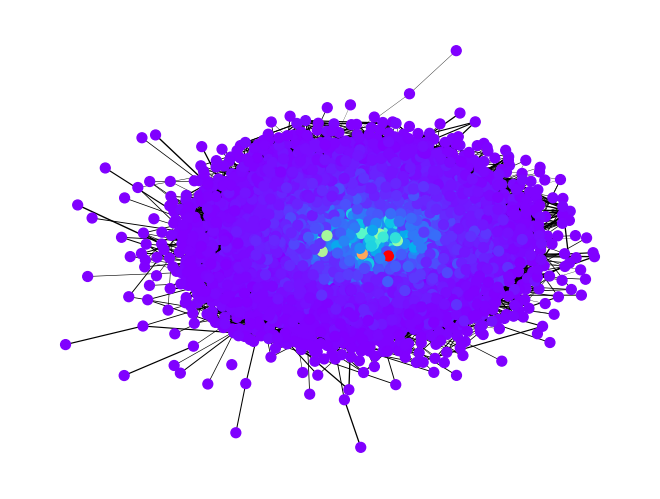

In [23]:
scaled_degree = [d[1]*10 for d in nwx.degree(tmp_G)]
nwx.draw_kamada_kawai(tmp_G,
        # Weights Based on Column
        width=list(nwx.get_edge_attributes(tmp_G, 'SemSim').values()),
        # Node size based on degree
        node_size=50,
        # Colour Based on Degree
        node_color=scaled_degree,
        # Set color map to determine colours
        cmap='rainbow',
        with_labels=False)

In [ ]:
## THIS IS TESTING NETWORK PACKAGE FOR VISUALIZATION PURPOSES
net = Network(notebook=True)
net.from_nx(tmp_G)

net.show("test_plot.html")

### Creating Adjacency Matrix

In [32]:
complexes_adj_mat = np.matrix(np.zeros((c_proteins, c_proteins)))

In [33]:
for idx, row in complexes_proteins_df.iterrows():
  protein_A = complexes_proteins_idx[row['ProteinA']]
  protein_B = complexes_proteins_idx[row['ProteinB']]
  sem_sim_score = row['SemSim']
  complexes_adj_mat[protein_A, protein_B] = sem_sim_score
  complexes_adj_mat[protein_B, protein_A] = sem_sim_score

In [34]:
np.fill_diagonal(complexes_adj_mat, 1)
complexes_adj_mat

matrix([[1.        , 0.58133333, 0.61166667, ..., 0.        , 0.        ,
         0.        ],
        [0.58133333, 1.        , 0.86866667, ..., 0.        , 0.        ,
         0.        ],
        [0.61166667, 0.86866667, 1.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         1.        ]])

### Vietoris Rips Persistence Filtration

In [15]:
## Define a functio to plot barcode diagrams
def plot_barcode(diag, dim, **kwargs):
    #dim = 0
    diag_dim = diag[dim]
    birth = diag_dim[:, 0]; death = diag_dim[:, 1]
    finite_bars = death[death != np.inf]
    if len(finite_bars) > 0:
        inf_end = 2 * max(finite_bars)
    else:
        inf_end = 2
    death[death == np.inf] = inf_end
    plt.figure(figsize=kwargs.get('figsize', (10, 5)))
    for i, (b, d) in enumerate(zip(birth, death)):
        if d == inf_end:
            plt.plot([b, d], [i, i], color='k', lw=kwargs.get('linewidth', 2))
        else:
            plt.plot([b, d], [i, i], color=kwargs.get('color', 'b'), lw=kwargs.get('linewidth', 2))
    plt.title(kwargs.get('title', 'Persistence Barcode'))
    plt.xlabel(kwargs.get('xlabel', 'Filtration Value'))
    plt.yticks([])
    plt.tight_layout()
    plt.show()

**Ripser Package**

In [ ]:
cmplx_adj_mat = np.asarray(complexes_adj_mat)
cmplx_dist_mat = 1 - cmplx_adj_mat ## Using the adjacency matrix as a correlation matrix

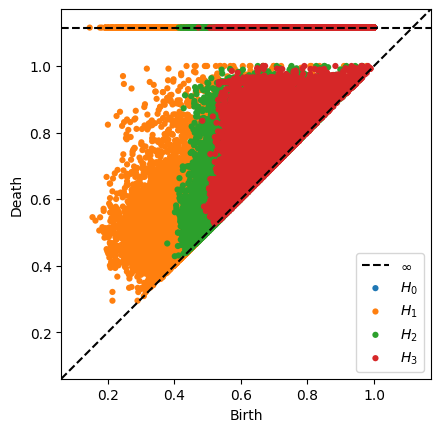

In [20]:
## TESTING
diagrams = ripser(complexes_adj_mat, distance_matrix=True, maxdim=3)['dgms']
rips_dist_mat_diags = diagrams

In [22]:
rips_dist_mat_diags = diagrams

/opt/homebrew/lib/python3.11/site-packages/persim/visuals.py:155: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim([x_down, x_up])
/opt/homebrew/lib/python3.11/site-packages/persim/visuals.py:156: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([y_down, y_up])


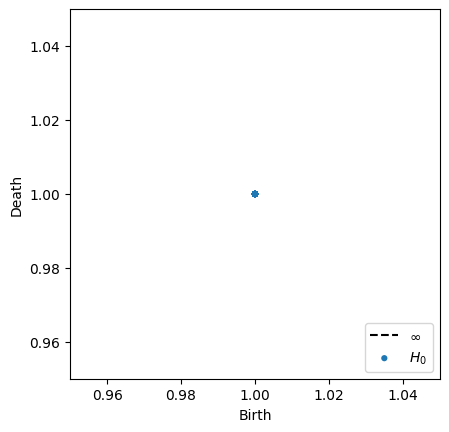

In [23]:
plot_diagrams(rips_dist_mat_diags, plot_only=[0])

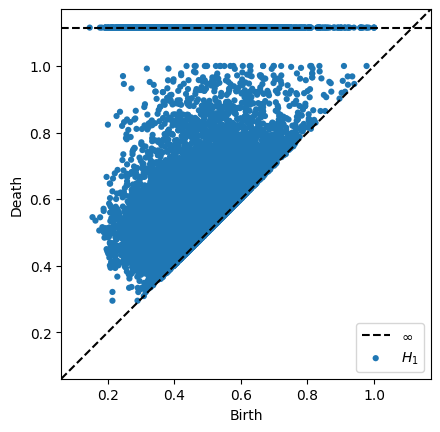

In [24]:
plot_diagrams(rips_dist_mat_diags, plot_only=[1])

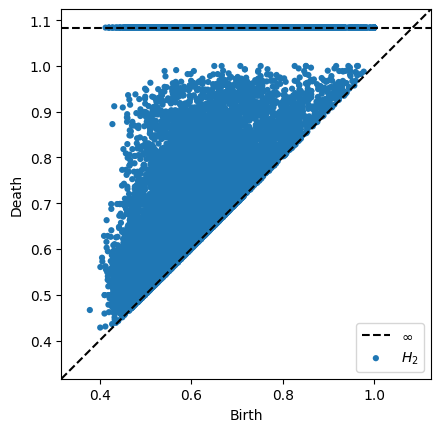

In [25]:
plot_diagrams(rips_dist_mat_diags, plot_only=[2])

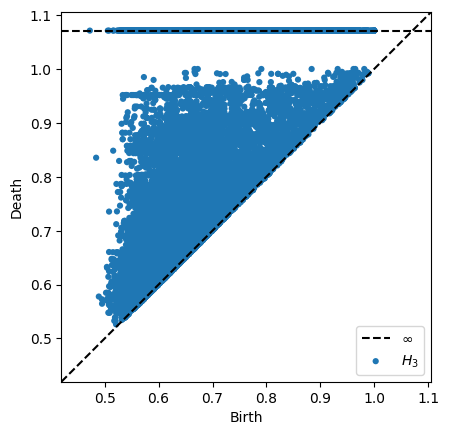

In [26]:
plot_diagrams(rips_dist_mat_diags, plot_only=[3])